<a href="https://colab.research.google.com/github/KLeeDE/PUS2020_KLee/blob/master/HW14/Copy_of_aenc_faces_UAPP667_20210512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for ETHICS OF DS 2021

This exercise is designed to think about bias in facial recognition software. 
To better understand how mathematical models can be biased, you will create a model that can increase the resolution of the image and try to identify in which cases the model underperforms and why.

ppt slides for lecture
https://slides.com/federicabianco/ethicsds_bianco

coding
https://github.com/fedhere/UInotebooks/blob/master/imgPorcessingABC/aenc_faces_instuctions.ipynb


AI ethics group
https://www.aiethicist.org/ai-organizations

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict (generate) high resolution images from low resolution ones
- test it on a headshot of yourself

In [2]:
# this will connect this notebook to your google drive. 
# You will need to approve the mounting point by choosing the account and 
# getting a code to be paster into this cell 
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# this loads the keras library for deep learning
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
from keras import backend as K
from keras.optimizers import Adamax


In [4]:
# this loads other functions
import glob # to look for date in the folders on the drive
import h5py # to save DL models after training and read saved models
from PIL import Image # to interact with images
import numpy as np # for mathematical operations in python
import pylab as pl # to make plots
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd /content/gdrive/


/content/gdrive


you can choose a different destination than the one below, but if you do then you need to download the data. make sure you uncomment the ```wget``` line of code below and the ones that follow as appropriate

In [6]:
cd Shareddrives/MLTSA2020/

/content/gdrive/Shareddrives/MLTSA2020


In [7]:
!pwd

/content/gdrive/Shareddrives/MLTSA2020


In [8]:
!ls

 facecheckpoints
 faces2.npy
 faces95
'faces95 (1).zip'
 faces.npy
'final presentations and reports'
'final team signup sheet.gsheet'
 imgreconstruct_10000.h5
 imgreconstruct2021_100000.h5
'midterm presentation slides'
'midterm reports'
'mitderm team signup sheet.gsheet'
'MLTSA 2020 final project slide deck2 .gslides'
'MLTSA 2020 proposal slide deck.gslides'
'MLTSA project proposal - midterm.gdoc'
 NazMalik.tiff
 pictures
'Screen Shot 2019-01-15 at 8.33.00 PM (1).png'
'Screen Shot 2019-01-15 at 8.33.00 PM.png'
 testimg.png


# load head shots from original data and save as numpy array - if you want you can skip to the "Read in data" section
faces95.zip is a compressed folder with headshots. It was removed from the internet after the "Obama Whitening Debackle". The code that follow was the original code to grab the data.  I have saved it and put it in a share drive that you should have access too. 

In [9]:
##DO NOT RUN:
## this code no longer works cause the endpoint was removed
#!wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip

In [10]:
##DO NOT RUN:
## the file is already unzipped in the shared drive so you do not need to run this
#!unzip faces95\ \(1\).zip

In [11]:
## I saved the processed file but if you want you can uncomment the cells below to redo it
!ls faces95/*/*jpg

faces95/10/10.jpg	    faces95/3/15.jpg   faces95/53/18.jpg
faces95/10/11.jpg	    faces95/31/5.jpg   faces95/53/19.jpg
faces95/10/12.jpg	    faces95/3/16.jpg   faces95/53/1.jpg
faces95/10/13.jpg	    faces95/31/6.jpg   faces95/53/20.jpg
faces95/10/14.jpg	    faces95/3/17.jpg   faces95/53/2.jpg
faces95/10/15.jpg	    faces95/31/7.jpg   faces95/53/3.jpg
faces95/10/16.jpg	    faces95/3/18.jpg   faces95/53/4.jpg
faces95/10/17.jpg	    faces95/31/8.jpg   faces95/53/5.jpg
faces95/10/18.jpg	    faces95/3/19.jpg   faces95/53/6.jpg
faces95/10/19.jpg	    faces95/31/9.jpg   faces95/53/7.jpg
faces95/10/1.jpg	    faces95/3/1.jpg    faces95/53/8.jpg
faces95/10/20.jpg	    faces95/3/20.jpg   faces95/53/9.jpg
faces95/10/2.jpg	    faces95/32/10.jpg  faces95/5/3.jpg
faces95/10/3.jpg	    faces95/32/11.jpg  faces95/54/10.jpg
faces95/10/4.jpg	    faces95/32/12.jpg  faces95/54/11.jpg
faces95/10/5.jpg	    faces95/32/13.jpg  faces95/54/12.jpg
faces95/10/6.jpg	    faces95/32/14.jpg  faces95/54/13.jpg
faces95/10/7.j

In [12]:
## there are 1400 images so this is slow
flist = glob.glob("faces95/*/*jpg")
flist.remove([f for f in flist if "prima" in f ][0])


In [13]:
N = len(flist)
N

1440

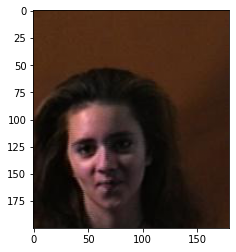

In [14]:
## this saves the data into a numpy array
im = Image.open(flist[0])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
## I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:]);

In [15]:
## skip and read the saved version if you have saved it (after the first time you run this cell)
imgs_orig = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
   if "prima" in f: continue
   if not i%50: print(i)

   im = Image.open(f)
   np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
   # here I collect the certain portion of each image 
   # from pixel 25 to 165 on the x and y axis (25:165)
   # and subsampling by a factor 2 (25:165:2)
   # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
   imgs_orig[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#np.save("faces2.npy", imgs)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400



## read in data

I saved the data in a numpy array: this way you can read it in more quickly. 

In [16]:
#imgs_orig = np.load("faces2.npy")

In [17]:
print("""There are {} images 
each {}x{} pixels and {} color channels""".format(*imgs_orig.shape))

There are 1440 images 
each 70x70 pixels and 1 color channels


# create input-output pairs
we want to create a model that can guess how a high resolution version of a low resolution headshot would look. We need to give it examples of low-res--high-res pairs. To do that we artificially lower the resolution of some images.

## make a copy of the original before you lower the resolution#

In [18]:
#imgs orig is the full resolution image
imgs = imgs_orig.copy()

In [19]:
# this creates a lower the resolution version of the image: reads every other pixel
imgs = imgs[:,::2,::2]
imgs[0].shape

(35, 35, 1)

In [20]:
print("""There {} low resolution images are 
each {}x{} pixels and {} color channels""".format(*imgs.shape))

There 1440 low resolution images are 
each 35x35 pixels and 1 color channels


In [21]:
print("The number of pixels in each image is {}".format(np.prod(imgs[0].shape)))

The number of pixels in each image is 1225


## generate a train and test set
The target variable will be a full resolution image set and the low input the lower resolution one

An autoencoder is traditionally trained to learn how to reproduce itself: input=target

We want to create a model that can increase the resolution of images: we will give the low resolution images as input and the high resolution image counterpart as target. Hovering over the function you can see what arguments it takes:

```train_test_split(input, target, test_size, random_state)```

In [26]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs_orig, test_size = .05, random_state=1)

In [27]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1368, 35, 35, 1), (72, 35, 35, 1), (1368, 70, 70, 1), (72, 70, 70, 1))

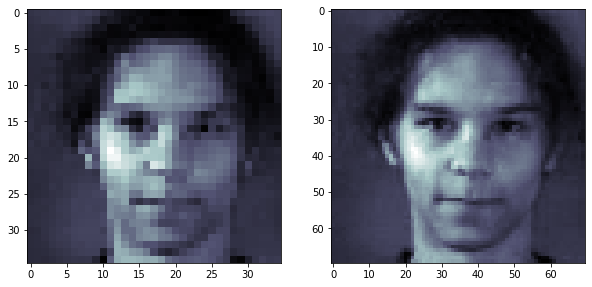

In [28]:
ax = pl.figure(figsize=(10,5)).subplots(1,2)
ax[0].imshow(np.squeeze(X_tr[0]), cmap="bone");
ax[1].imshow(np.squeeze(y_tr[0]), cmap="bone");

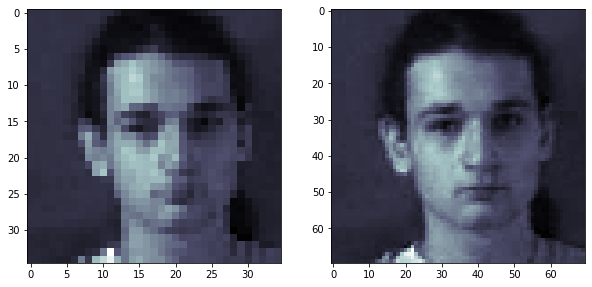

In [29]:
ax = pl.figure(figsize=(10,5)).subplots(1,2)
ax[0].imshow(np.squeeze(X_tr[1]), cmap="bone");
ax[1].imshow(np.squeeze(y_tr[1]), cmap="bone");

In [30]:
# this cell of code flattens the images: puts all pixels in a row
# this is apprioriate if the neural network does not use convolutional layers
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [31]:
input_dim = X_tr[0].shape

# build an autoencoder model

model.add([....] 
## add Dense layers - type Dense to see how to use the function to create a layer
## remember that the network should have an hour glass shape


In [33]:
# instantiate a sequential model: a deep neural network
model = Sequential()

#Encoder: reduces the size of the original image
model.add(Dense(256, activation='relu', input_dim=1225))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(4900, activation='relu'))
    
# choose the optimizer and the learning rate
opt = Adamax(
    learning_rate=0.005)

#compile the model choosing the loss and the metrics to keep track of
model.compile(optimizer=opt, loss='mse',
              metrics=['mae', 'acc'])
#alternative options for optimizing optimizer="adadelta", loss="kullback_leibler_divergence")

In [34]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               313856    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1225)              314825    
_________________________________________________________________
dense_4 (Dense)              (None, 4900)              6007400   
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## train model OR you can skip and load the pretrained I saved for you!
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [35]:
# only use this if you are in your own folder
# !mkdir facecheckpoints

In [36]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback, EarlyStopping
# this callback allows us to not to wast training time:
# if the validation loss does not improve for N epochs in a row training stops
patience = EarlyStopping(patience=20)
# other callbacks that can be used to save intermediate training steps - only use if you are in your own folder
# filepath = "facecheckpoints/OneHotEncodedweights-improvement-{epoch:02d}-{loss:.4f}.hd5" 
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
#                              save_best_only=True, mode='min')


In [38]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=1000, #with the patience callback I can set lots of epochs 
                    validation_split=0.2,
                    batch_size=150, verbose=1,
                    callbacks=[patience])#, checkpoint])
#model.save("facecheckpoints/imgreconstruct2021_100000.h5")

Epoch 1/1000
8/8 [==============================] - 3s 41ms/step - loss: 11.7739 - mae: 1.5878 - acc: 5.8055e-04 - val_loss: 0.1096 - val_mae: 0.2634 - val_acc: 0.0000e+00
Epoch 2/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0900 - mae: 0.2337 - acc: 7.4135e-04 - val_loss: 0.0560 - val_mae: 0.1747 - val_acc: 0.0000e+00
Epoch 3/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0507 - mae: 0.1662 - acc: 0.0029 - val_loss: 0.0396 - val_mae: 0.1444 - val_acc: 0.0000e+00
Epoch 4/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0377 - mae: 0.1412 - acc: 0.0000e+00 - val_loss: 0.0358 - val_mae: 0.1371 - val_acc: 0.0000e+00
Epoch 5/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0343 - mae: 0.1342 - acc: 4.3241e-04 - val_loss: 0.0343 - val_mae: 0.1342 - val_acc: 0.0000e+00
Epoch 6/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0333 - mae: 0.1320 - acc: 0.0026 - val_loss: 0.0337 - val_mae: 0.1326 - v

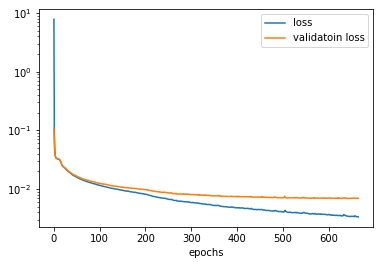

In [39]:
pl.plot(np.array(history.history['loss']), label="loss")
pl.plot(np.array(history.history['val_loss']), label="validatoin loss")
pl.xlabel("epochs")
pl.yscale('log')
pl.legend();
#pl.xscale('log')


In [40]:
## READ IN THE SAVED MODEL
##!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
#model.load_weights("facecheckpoints/imgreconstruct2021_100000.h5")

## predict

now that the model is trained it can be used to make prediction: this for us mean to crete high resolution image versions of low resolution imputs

In [41]:
outim = model.predict(X_te)
# the output if a high res image for each image in input
outim.shape

(72, 4900)

In [42]:
# to be read as images the predictions have to be organized in pizel rows and columns
outim[0].reshape(imgs_orig[0].shape).shape

(70, 70, 1)

In [43]:
import scipy
def compareinout(i, outim, X_te):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  print("similarity {:.2f}".format(scipy.stats.entropy(outim[i], y_te[i])))


plot some input-outpu pairs and the predictions

1 :	input		   prediction		target
similarity inf


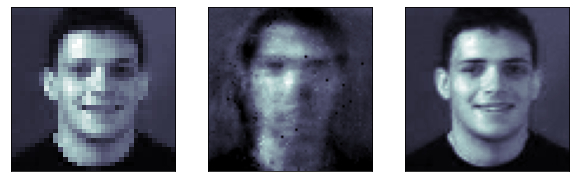

2 :	input		   prediction		target
similarity inf


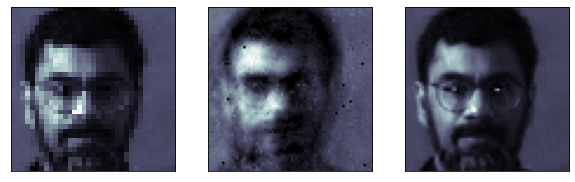

3 :	input		   prediction		target
similarity 0.08


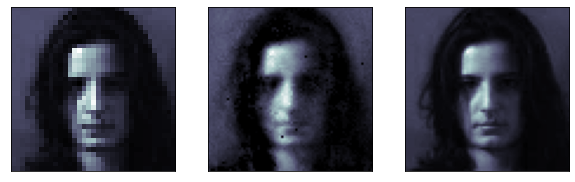

4 :	input		   prediction		target
similarity 0.03


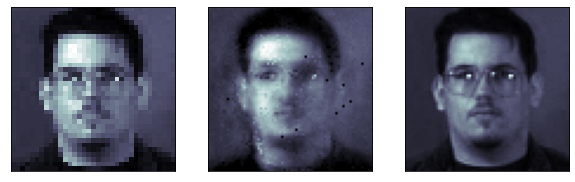

5 :	input		   prediction		target
similarity inf


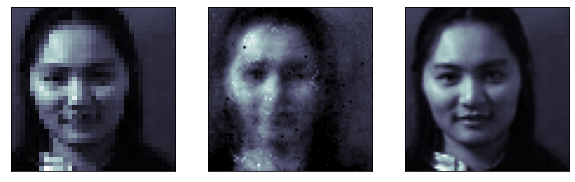

6 :	input		   prediction		target
similarity 0.06


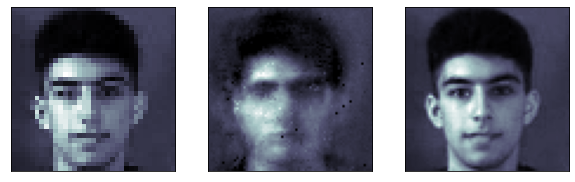

7 :	input		   prediction		target
similarity inf


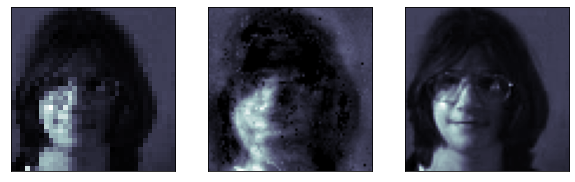

8 :	input		   prediction		target
similarity 0.02


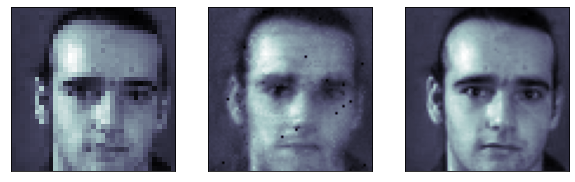

9 :	input		   prediction		target
similarity 0.03


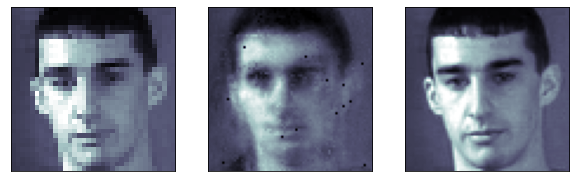

10 :	input		   prediction		target
similarity 0.02


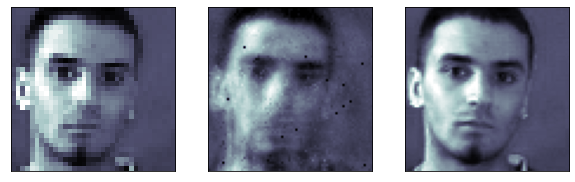

11 :	input		   prediction		target
similarity 0.02


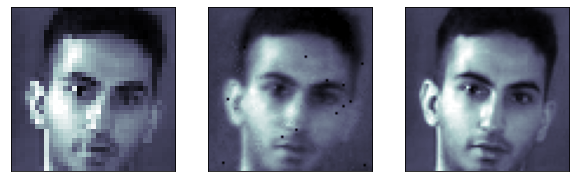

12 :	input		   prediction		target
similarity 0.02


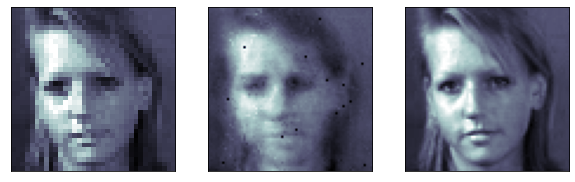

13 :	input		   prediction		target
similarity inf


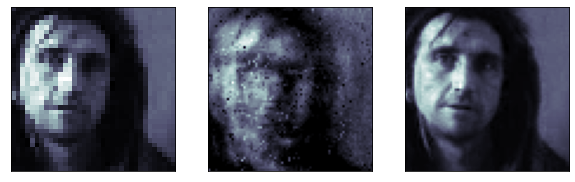

14 :	input		   prediction		target
similarity inf


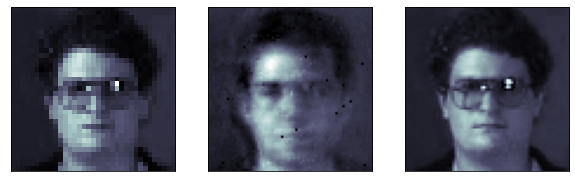

15 :	input		   prediction		target
similarity inf


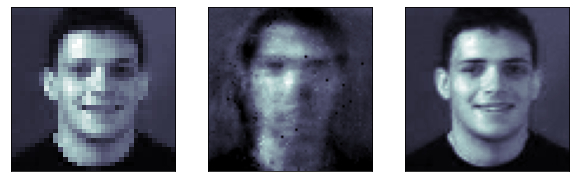

16 :	input		   prediction		target
similarity 0.03


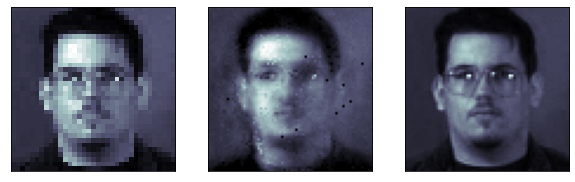

17 :	input		   prediction		target
similarity inf


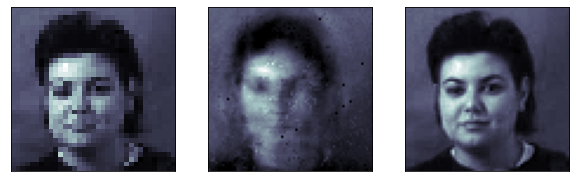

18 :	input		   prediction		target
similarity 0.03


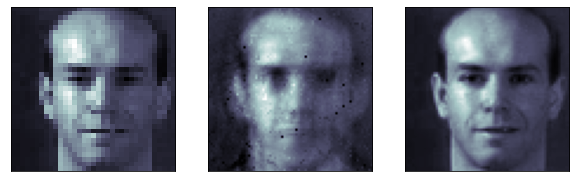

19 :	input		   prediction		target
similarity 0.02


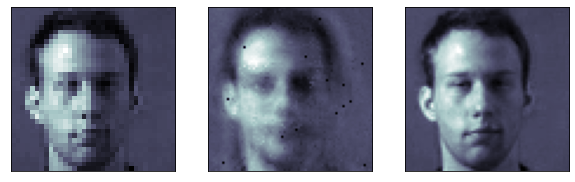

20 :	input		   prediction		target
similarity inf


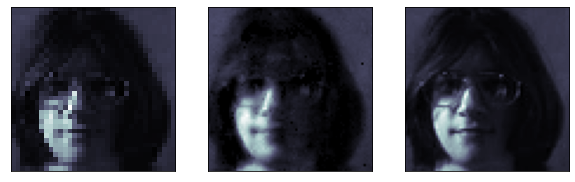

21 :	input		   prediction		target
similarity 0.03


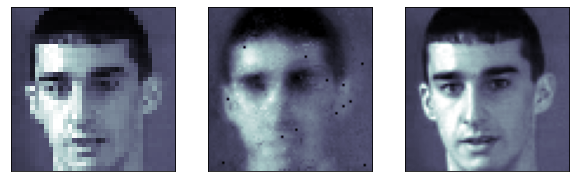

22 :	input		   prediction		target
similarity 0.03


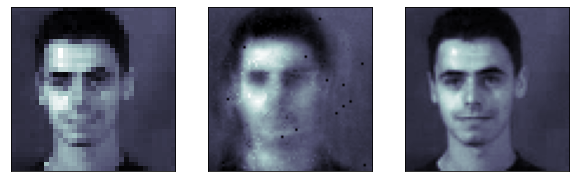

23 :	input		   prediction		target
similarity inf


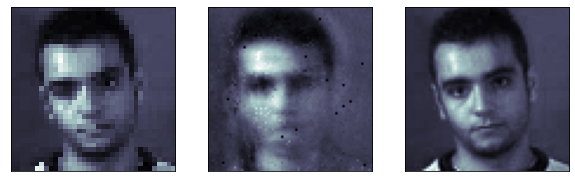

24 :	input		   prediction		target
similarity 0.02


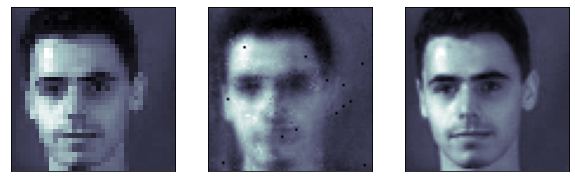

25 :	input		   prediction		target
similarity 0.09


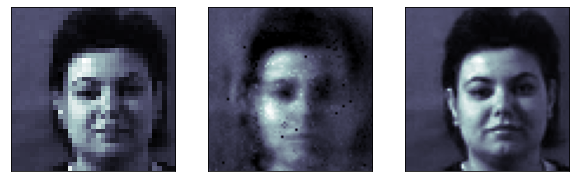

26 :	input		   prediction		target
similarity 0.13


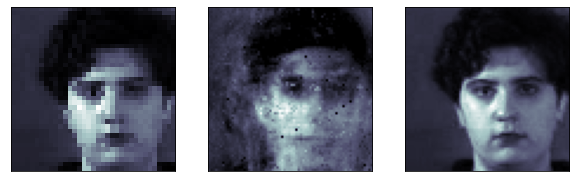

27 :	input		   prediction		target
similarity 0.03


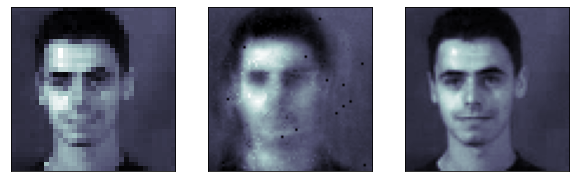

28 :	input		   prediction		target
similarity inf


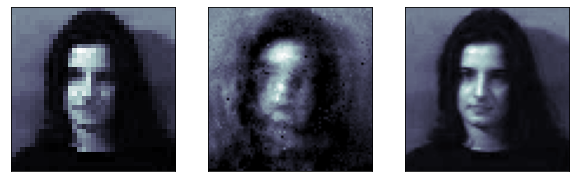

29 :	input		   prediction		target
similarity 0.03


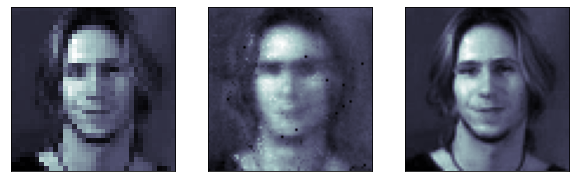

30 :	input		   prediction		target
similarity inf


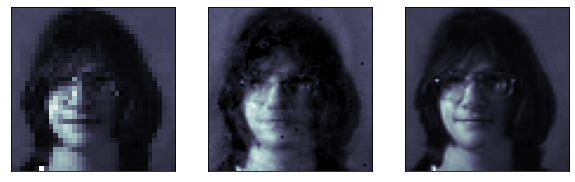

In [44]:
np.random.seed(123)
# pick a few random test images
for i in range(30):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t   prediction\t\ttarget")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

inspet the imput data: for each of 72 persons in the dataset there are 20 images. inspect one per person

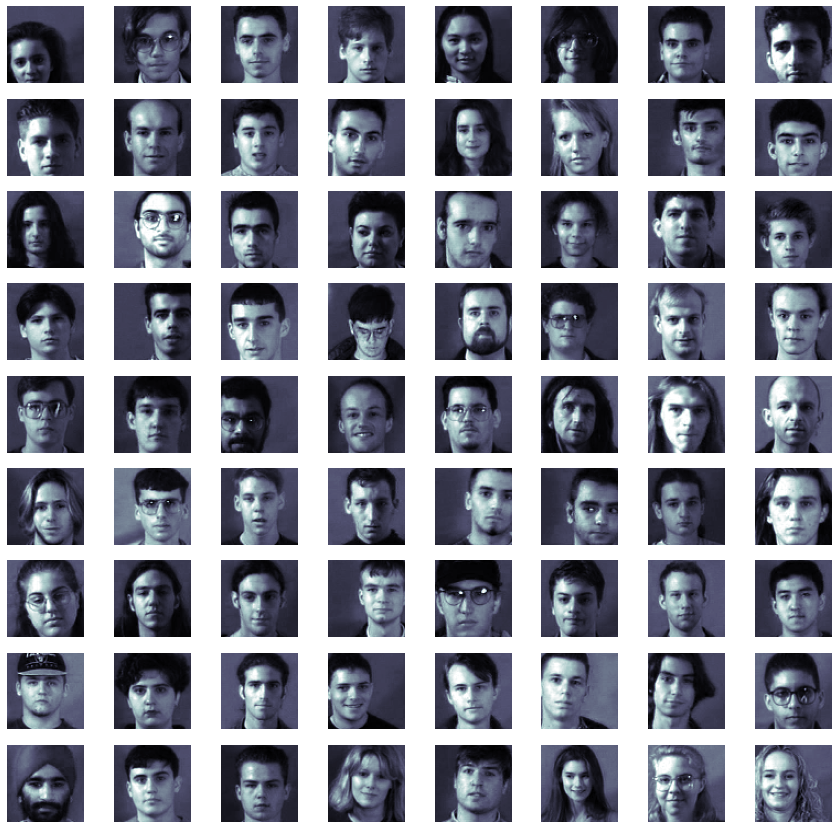

In [68]:
folders = glob.glob("faces95/*")
axs = pl.figure(figsize=(15,15)).subplots(9,8)

for i,f in enumerate(folders):
  #im = Image.open(f + "/1.jpg")
  np_im = numpy.array(imgs_orig[i*20].reshape(imgs_orig[0].shape[:-1])) 
  axs[i//8][i%8].imshow(np_im, cmap='bone')
  axs[i//8][i%8].axis('off')

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [47]:
from google.colab import files
uploaded = files.upload()

Saving Kyungmin.jpg to Kyungmin.jpg


In [48]:
!ls

 18173173.jpg
 facecheckpoints
 faces2.npy
 faces95
'faces95 (1).zip'
 faces.npy
'final presentations and reports'
'final team signup sheet.gsheet'
'IMG_20190509_122155[1].jpg'
 imgreconstruct_10000.h5
 imgreconstruct_10000.h5.1
 imgreconstruct_10000.h5.2
 imgreconstruct_10000.h5.3
 imgreconstruct2021_100000.h5
 Kyungmin.jpg
'midterm presentation slides'
'midterm reports'
'mitderm team signup sheet.gsheet'
'MLTSA 2020 final project slide deck2 .gslides'
'MLTSA 2020 proposal slide deck.gslides'
'MLTSA project proposal - midterm.gdoc'
 naz.jpg
 NazMalik.tiff
 pictures
'Screen Shot 2019-01-15 at 8.33.00 PM (1).png'
'Screen Shot 2019-01-15 at 8.33.00 PM.png'
 testimg.png


In [51]:
imme = Image.open('Kyungmin.jpg')

In [52]:
numpy.array(imme).shape

(427, 319, 3)

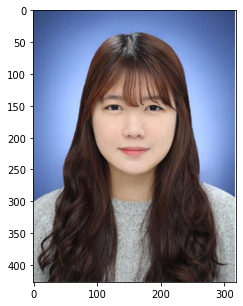

In [53]:
pl.imshow(numpy.array(imme))

**figure out how to shape it to make it the right number of pixels**

In [79]:
Nsamp = ?

SyntaxError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  


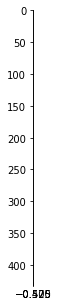

In [80]:
testimage = numpy.array(imme)[:Nsamp*35,450:Nsamp*35+450, :3].mean(axis=-1)
pl.imshow(testimage, cmap="bone")

In [63]:
print(35*Nsamp)

[[25.11764706 22.78431373 20.58823529 18.52941176 16.33333333]
 [26.21568627 24.43137255 21.82352941 19.90196078 17.01960784]
 [27.31372549 25.39215686 23.19607843 20.58823529 17.84313725]
 [28.41176471 26.76470588 24.01960784 21.54901961 18.39215686]
 [28.82352941 27.45098039 24.56862745 21.96078431 19.07843137]
 [29.09803922 28.1372549  25.39215686 22.37254902 19.21568627]
 [18.94117647 28.2745098  25.94117647 22.92156863 19.35294118]
 [ 7.82352941 28.41176471 25.80392157 22.64705882 18.52941176]
 [ 6.17647059 28.1372549  25.39215686 21.82352941 18.11764706]
 [ 6.17647059 27.45098039 24.43137255 21.         17.01960784]
 [ 5.21568627 24.84313725 22.78431373 19.62745098 15.92156863]
 [ 2.88235294 21.82352941 21.41176471 17.98039216 14.96078431]
 [ 4.52941176 16.19607843 29.23529412 16.33333333 13.8627451 ]
 [ 8.64705882  2.60784314 28.         29.78431373 30.05882353]
 [ 4.39215686  6.45098039 20.58823529 27.7254902  28.        ]
 [ 3.01960784  5.21568627  7.1372549  27.45098039 31.01

low resolution version
subsampling by 25

In [64]:
pl.imshow(testimage[::Nsamp,::Nsamp], cmap="bone")

NameError: ignored

In [ ]:
pl.imshow(model.predict(np.array([testimage[::Nsamp,::Nsamp].flatten() * 1.0 / 
                                  testimage[::Nsamp,::Nsamp].max()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');